## 1. Derivation of the world equilibrium

We have two countries $i\in\{H,F\}$, two goods $g\in\{M,A\}$, and for each country:

- **Endowments:**  
  $\bar L_i$ units of labor (mobile),  
  $\bar K_i$ units of capital (specific to manufacturing),  
  $\bar T_i$ units of land (specific to agriculture).

- **Technologies:**
  $
    Y_{i,M} = Z_{i,M}\,K_i^{\beta_i}\,L_{i,M}^{1-\beta_i}, 
    \quad
    Y_{i,A} = Z_{i,A}\,T_i^{\beta_i}\,L_{i,A}^{1-\beta_i},
    \quad \beta_i\in(0,1).
  $

- **Labor–price FOCs (zero profits):**  
  $
    P_M(1-\beta_i)Z_{i,M}
      \Bigl(\tfrac{K_i}{L_{i,M}}\Bigr)^{\beta_i}
      = w_i,
    \quad
    P_A(1-\beta_i)Z_{i,A}
      \Bigl(\tfrac{T_i}{L_{i,A}}\Bigr)^{\beta_i}
      = w_i.
  $
  ⇒ at any $p\equiv P_M/P_A$,
  $
    \underbrace{\frac{P_MZ_{i,M}}{P_AZ_{i,A}}
      \Bigl(\frac{K_i}{T_i}\Bigr)^{\!\beta_i}}_{\Omega_i(p)}
    = \frac{L_{i,M}}{L_{i,A}},
    \quad
    L_{i,M}(p)=\frac{\Omega_i(p)}{1+\Omega_i(p)}\,\bar L_i,
    \quad
    L_{i,A}(p)=\bar L_i - L_{i,M}(p).
    \tag{1}
  $

- **Sectoral outputs** (as functions of $p$):
  $
    Y_{i,M}(p)
      = Z_{i,M}\,K_i^{\beta_i}\,(L_{i,M}(p))^{1-\beta_i},
    \quad
    Y_{i,A}(p)
      = Z_{i,A}\,T_i^{\beta_i}\,(L_{i,A}(p))^{1-\beta_i}.
    \tag{2}
  $

---

### 1.1 World aggregates

- **Relative supply**  
  $
    RS(p)
      = \frac{Y^W_M(p)}{Y^W_A(p)}
      = \frac{\sum_i Y_{i,M}(p)}{\sum_i Y_{i,A}(p)}.
    \tag{3}
  $

- **Relative demand**  
  Total income in country $i$ is
  $\,I_i(p)=P_MY_{i,M}(p)+P_AY_{i,A}(p)$. (since $P_A$ is the numeraire, then: $I_i(p)=p Y_{i,M}(p)+Y_{i,A}(p))\,$  Cobb–Douglas shares give
  $Q_{i,M}=(1-\alpha_i)I_i/P_M,\;Q_{i,A}=\alpha_iI_i/P_A$.  Hence
  $
    RD(p)
      = \frac{\sum_i Q_{i,M}(p)}{\sum_i Q_{i,A}(p)}
      = \frac{\sum_i(1-\alpha_i)I_i(p)/P_M}
             {\sum_i \alpha_iI_i(p)/P_A}
      = \frac{\sum_i(1-\alpha_i)I_i(p)}
             {\sum_i \alpha_iI_i(p)}\;\frac1p.
    \tag{4}
  $

- **Market‐clearing**  
  $
    RS(p^*) = RD(p^*)
    \quad\Longrightarrow\quad
    F(p)\equiv RS(p)-RD(p)=0,
  $
  which has a unique solution $p^*=P_M/P_A$.


## 2. Python implementation

Below is a step-by-step mapping from the derivation into code.  Students
can paste this into a Jupyter cell, tweak the primitives, and see how
each formula is implemented.


In [8]:
# =====================================================
#  WORLD EQUILIBRIUM IN THE SPECIFIC-FACTORS MODEL
# =====================================================

# 1. PRIMITIVES
Z_M = {'H':1.0, 'F':0.8}      # TFP in manufacturing
Z_A = {'H':1.0, 'F':0.6}      # TFP in agriculture
K   = {'H':4.0, 'F':2.0}      # capital endowments
T   = {'H':3.0, 'F':1.0}      # land endowments
L   = {'H':5.0, 'F':5.0}      # labor endowments
beta= {'H':0.40,'F':0.40}     # Cobb–Douglas share β_i
alpha={'H':0.50,'F':0.50}     # consumption share α_i

# 2. DOMESTIC labor split Ω_i(p)  -- implements eqn (1)
def Omega(i, p):
    return (p * Z_M[i]/Z_A[i])**(1.0/beta[i]) * (K[i]/T[i])

def Lm(i, p):
    ω = Omega(i, p)
    return (ω/(1+ω)) * L[i]

def La(i, p):
    return L[i] - Lm(i, p)

# 3. OUTPUTS Y_{i,g}(p)  -- implements eqn (2)
def Ym(i, p):
    return Z_M[i] * K[i]**beta[i] * Lm(i,p)**(1-beta[i])

def Ya(i, p):
    return Z_A[i] * T[i]**beta[i] * La(i,p)**(1-beta[i])

# 4. WORLD Relative Supply RS(p)  -- eqn (3)
def RS(p):
    num = sum(Ym(i,p) for i in ['H','F'])
    den = sum(Ya(i,p) for i in ['H','F'])
    return num/den

# 5. WORLD Relative Demand RD(p)  -- eqn (4)
def RD(p):
    # income I_i = P_M Y_M + P_A Y_A = p*Y_M + 1*Y_A
    I = {i: p*Ym(i,p) + Ya(i,p) for i in ['H','F']}
    num = sum((1-alpha[i])*I[i]/p for i in ['H','F'])
    den = sum(alpha[i]*I[i]   for i in ['H','F'])
    return num/den

# 6. EXCESS DEMAND
def excess_demand(p):
    return RS(p) - RD(p)

# 7. BISECTION 
def bisect_root(f, a, b, tol=1e-6, max_iter=100):
    fa, fb = f(a), f(b)
    if fa*fb > 0:
        raise ValueError("Root not bracketed")
    for _ in range(max_iter):
        m = 0.5*(a+b)
        fm = f(m)
        if abs(fm)<tol or (b-a)<tol:
            return m
        if fa*fm<0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    raise RuntimeError("No convergence")

# 8. AUTOMATIC BRACKETING & SOLVE
p_low, p_high = 2, 2
while excess_demand(p_low) > 0:
    p_low *= 0.1
while excess_demand(p_high) < 0:
    p_high *= 10

p_star = bisect_root(excess_demand, p_low, p_high)
print("Equilibrium P_M/P_A =", p_star)

Equilibrium P_M/P_A = 0.7707118511199951


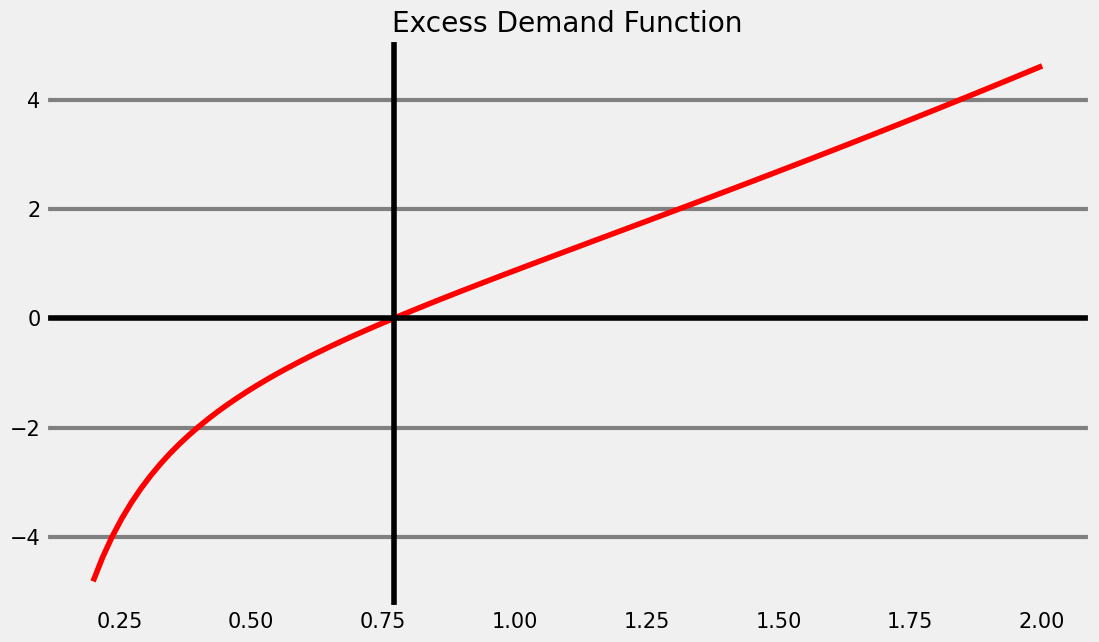

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')

# Declare figure
fig, ax = plt.subplots(figsize=(12,7))

x = np.linspace(p_low,p_high,100)
y = [excess_demand(i) for i in x]
# Plot line
plt.plot(x, y, color='red')
plt.axhline(0, color='black')
plt.axvline(p_star, color='black')
plt.title(r'Excess Demand Function')
# Configure axes
ax.yaxis.grid(which="major", color='grey', linewidth=3)
ax.xaxis.grid(which="major", linewidth=0)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()